# Deep Doggie Net - My Personal Doggie Detector

In this project I am going to use transfer learning to quickly build up a model that is capable of accurately differentiating between my two dogs: Gentil and Loki. One is an Atlas Sherperd named Gentil, native to Morocco, and the other is a German Shepherd named Loki. They have some similar features, however they are different colors and the German one is about double in size. 

I will be loading in a ResNet50 convolutional neural network, pretrained on the imagenet database, and modifying the model to only differentiate between my two dogs. To do this, all of the hidden layers will be "frozen", besides the final layer. I will replace this layer, which previously classified 1000 classes, and train my images on a new final layer that is a binary classifier: classifying each image as either Gentil or Loki.

This project is heavily inspired by Francois Chollet's book Deep Learning with Python.

### Data Gathering Process

To gather the images needed for training, I took three approaches. First, I took several pictures of the dogs myself. This felt rather time consuming and I was not always home to do so. I wanted to find a quicker way to gather images online. Thus, next, I wrote a script that requested images of german shepherds from unsplash.com's API. This script can be found in my github. With this method I was able to download up to 50 images of german shepherds per hour (there are no Atlas Shepherd's on the website). Although these were not pictures of my exact dog, adding pictures of the same dog breed to the training data of Loki helped train the model and improve its accuracy. Lastly, I used a technique of data augmentation through Keras, morphing all of my training images to create new images for my model to train on.

In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

Instructions for updating:
Colocations handled automatically by placer.


C:\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

"Include_top" is set to False, removing the densely connected classifier pertaining to these 1000 classes. I will be replacing this with my own classifier that only labels two classes: Loki and Gentil, the names of my two dogs.

## Reading in train, test, and val data

In [2]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C://Users//brode//Documents//Data Analysis//Deep Doggie//Doggies'
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

In [3]:
## Loading data and passing through ResNet

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 10

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 184)
validation_features, validation_labels = extract_features(validation_dir, 44)
test_features, test_labels = extract_features(test_dir, 26)

Found 184 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


With all of images loaded in, we will be starting out with a total of only 184 images for training this deep learning model.

In [4]:
# reshaping images for densely connected classifier

train_features = np.reshape(train_features, (184, 5 * 5 * 2048))
validation_features = np.reshape(validation_features, (44, 5 * 5 * 2048))

In [5]:
# adding the new dense layer of 256 units and a single unit sigmoid function for binary classification

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=5 * 5 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 184 samples, validate on 44 samples
Epoch 1/50
184/184 [==============================] - 4s 21ms/step - loss: 0.7362 - acc: 0.7935 - val_loss: 0.2602 - val_acc: 0.9091
Epoch 2/50
184/184 [==============================] - 1s 5ms/step - loss: 0.0520 - acc: 0.9783 - val_loss: 0.1969 - val_acc: 0.9091
Epoch 3/50
184/184 [==============================] - 1s 5ms/step - loss: 0.0136 - acc: 0.9946 - val_loss: 0.1822 - val_acc: 0.9091
Epoch 4/50
184/184 [==============================] - 1s 6ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.2018 - val_acc: 0.9091
Epoch 5/50
184/184 [==============================] - 1s 5ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.1931 - val_acc: 0.9091
Epoch 6/50
184/184 [==============================] - 1s 5ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1912 - val_acc: 0.9091

After 50 epochs, my model is perfect on the training data, with 100% accuracy and very good on the validation data, around 95% accuracy. I am going to use data augmentation to create even more images to train on, hopefully improving the model's accuracy even further.

## Data Augmentation

The data augementation technique will increase the number of images that the model trains on by modifying the characteristics of each image, thereby creating new images. This technique should improve the accuracy of the model. I will begin by displaying how data augmentation makes the new images appear.

In [6]:
# specifying to ImageDataGenerator how the new images will be modified

datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

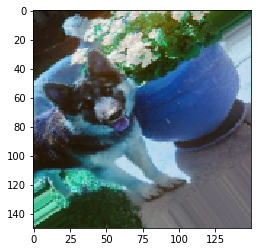

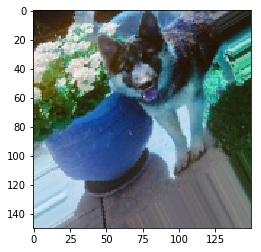

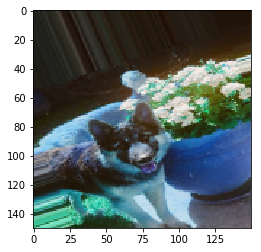

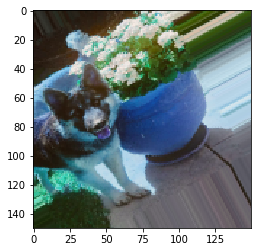

In [7]:
# showing examples of how the augmented images will look

loki_dir = os.path.join(base_dir, 'Train//Loki')

fnames = [os.path.join(loki_dir, fname) for
     fname in os.listdir(loki_dir)]

img_path = fnames[72]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

These new photos show Loki at different angles, zooms, rotations, and sheers. Creating new data for the model to extract features from.

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
# Freezing the weights

conv_base.trainable = False
print(len(model.trainable_weights))

4


In [11]:
# applyping data augmentation to morph the training images

train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50)

Found 184 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 304s 3s/step - loss: 0.1985 - acc: 0.9275 - val_loss: 0.2662 - val_acc: 0.9318
Epoch 2/5
100/100 [==============================] - 264s 3s/step - loss: 0.0911 - acc: 0.9640 - val_loss: 0.2121 - val_acc: 0.9545
Epoch 3/5
100/100 [==============================] - 262s 3s/step - loss: 0.0235 - acc: 0.9910 - val_loss: 0.2886 - val_acc: 0.9773
Epoch 4/5
100/100 [==============================] - 259s 3s/step - loss: 0.0608 - acc: 0.9790 - val_loss: 0.2734 - val_acc: 0.9545
Epoch 5/5
100/100 [==============================] - 257s 3s/step - loss: 0.0392 - acc: 0.9820 - val_loss: 0.2241 - val_acc: 0.9545


Great! With data augmentation, my validation set accuracy goes to almost 98% on the third epoch! It is then back down to 95% on the 5th epoch, but this is still an improvement and we are definitely on the right track.

## Evaluating on Test Data

I have some final images saved under test, for a final verification. Let's see how the model does on these unseen images.

In [12]:
test_features = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=10,
        class_mode='binary')

Found 26 images belonging to 2 classes.


In [13]:
scores = model.evaluate_generator(test_features, steps=26, verbose=1) 
print("Accuracy = ", "{:.2%}".format(scores[1]))

26/26 [==============================] - 58s 2s/step
Accuracy =  100.00%


Great! My model performed with 100% accuracy on the test data. Finally, I will test on some sample images of my doggies and see how it performs.

## Testing on Sample Images

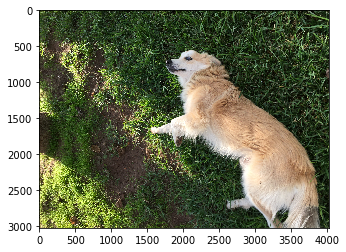

In [14]:
img_path = 'Gentil24.jpg'
img = image.load_img(img_path)
plt.imshow(img)
plt.show()

Here is a picture of my doggie Gentil. Let's see who the model predicts him to be.

In [15]:
def doggie_predictor(path):
    img = image.load_img(path, target_size=(150,150))
    
    # show the image
    plt.imshow(img)
    plt.show()
    
    # image preprocessing
    img_tensor = image.img_to_array(img)
    img_tensor = preprocess_input(img_tensor)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    # predict the image
    predict_class = model.predict_classes(img_tensor)
    probability = float(model.predict_proba(img_tensor))
    
    if predict_class == 0:
        print("It is Gentil!")
    else:
        print("It is Loki!")
        
    return print("Probability of being Loki: "+"{:.2%}".format(probability))

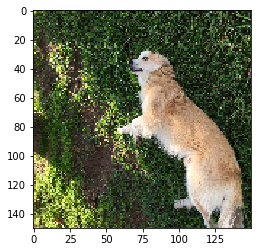

It is Gentil!
Probability of being Loki: 0.00%


In [16]:
path = 'Gentil24.jpg'
doggie_predictor(path)

My doggie predictor got it perfect! This is indeed Gentil. Next I will test on a picture of Loki as a puppy and wet from the rain. The model has never seen Loki this young before.

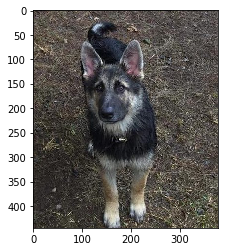

In [17]:
path = 'loki.jpg'
img = image.load_img(path)
plt.imshow(img)
plt.show()

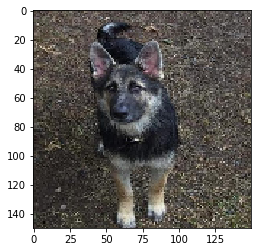

It is Loki!
Probability of being Loki: 100.00%


In [18]:
doggie_predictor(path)

Great job doggie detector! With using transfer learning from a model pretrained on the imagenet, I was able to create a super accurate image detection model, using a very low amount of data and relatively little computation power.